In [63]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [65]:
import optuna
import pandas as pd
import numpy as np
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix,classification_report
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.optim as optim
from nltk.stem import WordNetLemmatizer # lemmatizier
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import time

pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=50

from tqdm import tqdm,tqdm_notebook
tqdm.pandas(desc='my bar')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.setrecursionlimit(10000)



import re
def preprocessing(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    s = re.sub("@\w+", '',s) # removing mentions (@)
    s = re.sub("'\d+", '',s)
    s = re.sub("\d+", '',s)
    s = re.sub(r"[^\w\s]", '',s) # to remove symbols
    s = re.sub("http\w+", '',s)
    s = re.sub("\s[a-z]\s", '',s)
    s = s.strip()
    
    return s

from nltk.corpus import stopwords
# load stop words
stop_word = stopwords.words('english')

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
device

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


device(type='cuda')

In [66]:
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.info()
print(f'\n\n')
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB





,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [67]:
test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.info()
print(f'\n\n')
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB





,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


data shhape:  (10876, 2)
7613


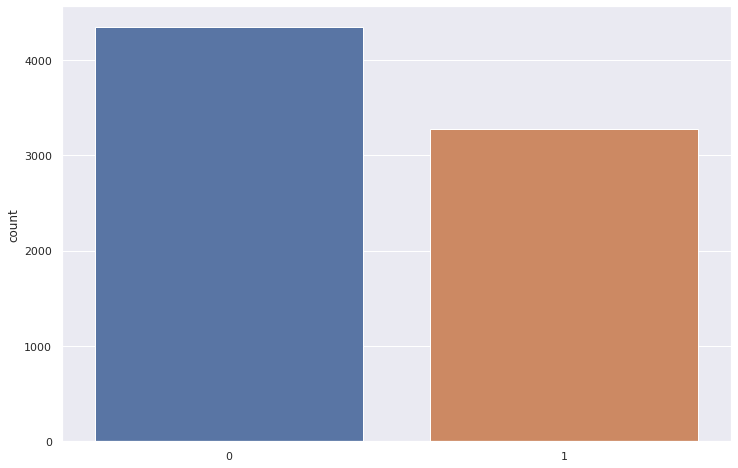

In [68]:
data=pd.concat([train,test])[['text','target']].reset_index(drop='True')
label=train['target'].values
print(f'data shhape: ',data.shape)
print(len(label))

sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(label);

In [69]:
data.text

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10871    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872    Storm in RI worse than last hurricane. My city...
10873    Green Line derailment in Chicago http://t.co/U...
10874    MEG issues Hazardous Weather Outlook (HWO) htt...
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

In [70]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['text']=data['text'].apply(lambda x : remove_emoji(x))

# -----------------------------------------------------------------------------------

# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text
# -----------------------------------------------------------------------------------
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
data['text']=data['text'].apply(lambda x : remove_URL(x))
# -----------------------------------------------------------------------------------


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

data['text']=data['text'].apply(lambda x : remove_html(x))
# -----------------------------------------------------------------------------------

import string
special = string.punctuation
from wordcloud import WordCloud
# -----------------------------------------------------------------------------------

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

data['text']=data['text'].apply(lambda x : remove_punct(x))

# -----------------------------------------------------------------------------------

def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""    
    tweet = ''.join([x for x in tweet if x in string.printable])
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

data['text']=data['text'].apply(lambda x : clean_tweets(x))

In [73]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    'ig': 'instagram',
    "zzz" : "sleeping bored and tired",

}

In [74]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
data["text"] = data["text"].apply(lambda x: convert_abbrev_in_text(x))

In [77]:
from nltk.corpus import stopwords

def tokenizer(texts):
    word_list=[]
    stop_word=set(stopwords.words('english'))
    for sent in texts:
        sent=sent.lower().split()
        for word in sent:
#             word=preprocessing(word)
            if word not in word_list :#stop_word and word != '' :
    
                word_list.append(word)
    
    corpus=Counter(word_list)     
    corpus_=sorted(corpus,key=corpus.get,reverse=True)
    one_hot_dict={w:i+1 for i,w in enumerate(corpus_)}
    
    
    train_list=[]
    for  sent in  texts:   
         train_list.append( [one_hot_dict[word] for word in sent.lower().split()
                           if word in one_hot_dict.keys()])
    
    
    
    
    return  train_list,one_hot_dict,corpus_
        
data_text,one_hot_dict,corpus_=tokenizer(data.text)
vocab_size=len(one_hot_dict)+1
print(f'vocab_size :{len(one_hot_dict)}')


vocab_size :22294


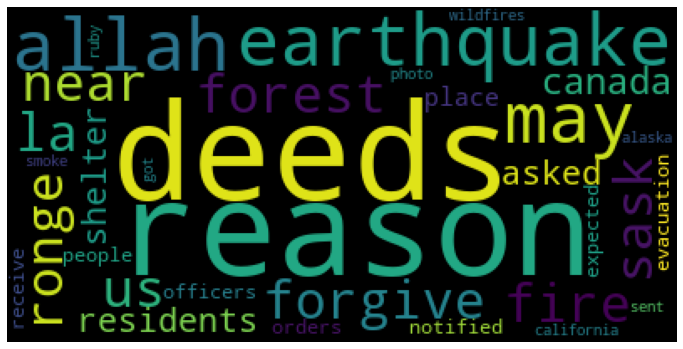

In [78]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [79]:
a=[len(x) for x in data_text]
max_len_index=a.index(max(a))
max_len_seq=len(data_text[max_len_index])
print(f'max length squence :{max_len_seq}')

#padding used to same size tensors
pad=max_len_seq
def padding(data,padd):
    for i,sent in enumerate(data):
        feature=np.zeros((1,padd),dtype=int) 
        if len(np.array(sent)) != 0:
            feature[:,-len(sent):]=np.array(sent)
            data[i]=feature
        else :
            data[i]=feature
    return data


data_text_padded=padding(data_text,pad) 
data_text_padded=np.array(data_text_padded)
print(f'data_text_padded shape: ',data_text_padded.shape)
data_train=data_text_padded[:train.shape[0]]
target_train=label
print(f'data train shape : {data_train.shape}')
print(f'Target train shape {target_train.shape}')

max length squence :34
data_text_padded shape:  (10876, 1, 34)
data train shape : (7613, 1, 34)
Target train shape (7613,)


In [80]:
data=TensorDataset(torch.tensor(np.array(data_train)),torch.tensor(target_train))
df_test=data_text_padded[len(target_train):]
print(f'Train data shape: {data_train.shape}')
print(f'Train data label shape: {label.shape}')
print(f'Test data shape: {df_test.shape}')

Train data shape: (7613, 1, 34)
Train data label shape: (7613,)
Test data shape: (3263, 1, 34)


In [81]:
class sentimentLSTM(nn.Module):
    def __init__(self,num_layers,batch_size,hidden_size,vocab_size,embed_size,prob,pad):
        super(sentimentLSTM,self).__init__()
        
        self.hidden_size=hidden_size
        self.embed=nn.Embedding(vocab_size,embed_size)
        self.embed_size=embed_size
        self.num_layers=num_layers
        self.prob=prob
        self.pad=pad
        self.lstm=nn.LSTM(input_size=self.embed_size,
                         hidden_size=self.hidden_size,
                         num_layers=self.num_layers,
                         batch_first=True)
        

        
        
        self.linear=nn.Linear(self.hidden_size,64)
        self.linear2=nn.Linear(64,1)
#         self.linear3=nn.Linear(32,32)
#         self.linear4=nn.Linear(32,1)
        self.drop=nn.Dropout(self.prob)
        self.relu=nn.ReLU()
#       self.sigmoid=nn.Sigmoid()
    

    
    def forward(self,init_hidden,batch_input):
        
        batch_sz=batch_input.shape[0]
        batch_input=batch_input.view(batch_sz,-1)
        batch_input=self.embed(batch_input)
        batch_input,hiddens=self.lstm(batch_input,init_hidden)
        batch_input=batch_input.contiguous().view(-1, self.hidden_size)
        
        batch_input=self.drop(batch_input)
        batch_input=self.relu(batch_input)
        batch_input=self.linear(batch_input) 
        
        batch_input=self.drop(batch_input)
        batch_input=self.relu(batch_input)
        batch_input=self.linear2(batch_input)  
        
#         batch_input=self.drop(batch_input)
#         batch_input=self.relu(batch_input)
#         batch_input=self.linear3(batch_input)  
        
#         batch_input=self.drop(batch_input)
#         batch_input=self.relu(batch_input)
#         batch_input=self.linear4(batch_input)
        
#       batch_input=self.sigmoid(batch_input)
        out=batch_input.view(batch_sz,self.pad, -1)   
        
        return out[:,-1],hiddens
    
    
    def get_x(self):
        return self.x

    def init_hidden(self,b):

        h0 = torch.zeros((self.num_layers,b,self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers,b,self.hidden_size)).to(device)
        hidden = (h0,c0)
        return hidden

In [82]:
# Train and evaluate the accuarcy of neural network model
def objective(trial,sentimentLSTM=sentimentLSTM,data=data,target=target_train,vocab_size=vocab_size,pad=pad):

    params = {'num_layers':trial.suggest_categorical('num_layers', [1,2]),
              'batch_size':trial.suggest_categorical('batch_size', [128,256,512]),
              'hidden_size':trial.suggest_categorical('hidden_size', [50,100,200]),
              'embed_size':trial.suggest_categorical('embed_size', [50,100,200]),
              'prob':trial.suggest_categorical('prob', [0.3,0.5,0.7,0.9]),
              'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.01,0.001]),
              'optimizer': trial.suggest_categorical("optimizer", ['Adam']),
               'pad':trial.suggest_categorical('pad', [31])
              }
    
    
    model_params={key:value   for key,value in params.items() if key not in('learning_rate','optimizer')}   
    
    model_params.update({'vocab_size':vocab_size})
    model_params.update({'pad':pad})
    
    kf=KFold(n_splits=3,shuffle=True,random_state=0)
    folds=list(kf.split(data,target))

    history_fold = {'train_f1':{'folds':[]},
                    'train_loss': {'folds':[]},
                    'train_preds':{'folds':[]},
                    'val_loss':{'folds':[]},
                    'val_f1':{'folds':[]},
                    'val_preds':{'folds':[]}}


    for fold,(train_idx, val_idx) in enumerate(folds):
        
        print(f'fold :{fold}')

        lstmModel=sentimentLSTM(**model_params).to(device)

        optimizer = getattr(torch.optim, params['optimizer'])(lstmModel.parameters(),lr=params['learning_rate'])
        criterion=nn.BCEWithLogitsLoss(reduction='sum')

                        
        train_data = TensorDataset(data.tensors[0][train_idx], data.tensors[1][train_idx])
        val_data = TensorDataset(data.tensors[0][val_idx], data.tensors[1][val_idx])

        train_loader=DataLoader(dataset=train_data,
                                shuffle=True,
                                batch_size=params['batch_size'], drop_last=True)

        val_loader=DataLoader(dataset=val_data,
                                shuffle=True,
                                batch_size=params['batch_size'], drop_last=True)

        for epoch in range(15):
            
            lstmModel.train()
            train_loss_sum=0
            train_preds=[]
            train_labels=[]
            h = lstmModel.init_hidden(params['batch_size'])


            for batch_idx,(train_inputs,train_label) in enumerate(train_loader):

                train_inputs=train_inputs.type(torch.LongTensor).to(device)
                train_label=train_label.type(torch.LongTensor).to(device)

                h = tuple([each.data for each in h])
        
                train_pred,hd=lstmModel(h,train_inputs) 
            
                optimizer.zero_grad()
                train_batch_loss=criterion(train_pred.float(),train_label.reshape(-1,1).float())
                train_batch_loss.backward()
                optimizer.step()
                
                train_loss_sum+=train_batch_loss.item() 
                train_labels.append(np.array(train_label.cpu()))
                train_preds.append(np.array([1 if i>0.3 else 0 for i in train_pred]))




            f1_train=f1_score(np.concatenate(train_labels),np.concatenate(train_preds))  
    
            history_fold['train_f1']['folds'].append({'fold_'+str(fold):f1_train})
            history_fold['train_loss']['folds'].append({'fold_'+str(fold):train_loss_sum})
            history_fold['train_preds']['folds'].append({'fold_'+str(fold):np.concatenate(train_preds)})

            
            lstmModel.eval() 
            val_loss_sum=0
            val_preds=[]
            val_labels=[]
            for batch_idx,(val_inputs,val_label) in enumerate(val_loader):

                val_inputs=val_inputs.type(torch.LongTensor).to(device)
                val_label=val_label.type(torch.LongTensor).to(device)

                h= tuple([each.data for each in h])
                val_pred,hd=lstmModel(h,val_inputs)
                
                val_batch_loss=criterion(val_pred.float(),val_label.reshape(-1,1).float())
                val_loss_sum+=val_batch_loss.item()


                val_labels.append(np.array(val_label.cpu()))
                val_preds.append(np.array([1 if i>0.3 else 0 for i in val_pred]))


            f1_val=f1_score(np.concatenate(val_labels),np.concatenate(val_preds))
            
            history_fold['val_f1']['folds'].append({'fold_'+str(fold):f1_val})
            history_fold['val_loss']['folds'].append({'fold_'+str(fold):val_loss_sum})
            history_fold['val_preds']['folds'].append({'fold_'+str(fold):np.concatenate(val_preds)})


            
            print(f'Epoch : {epoch}, Train_mean_f1 : {f1_train} ,Train_total_loss : {train_loss_sum} >----< validation_mean_f1 : {f1_val} ,Validation_total_loss : {val_loss_sum}')
     
    

    validation_f1=pd.DataFrame([pd.DataFrame(history_fold['val_f1']['folds'])[col].dropna().values  for col in pd.DataFrame(history_fold['val_f1']['folds']).columns]).mean(axis=0).max()
    train_f1=pd.DataFrame([pd.DataFrame(history_fold['train_f1']['folds'])[col].dropna().values  for col in pd.DataFrame(history_fold['val_f1']['folds']).columns]).mean(axis=0).max()

    trial.set_user_attr("history", history_fold)
    print(f"train f1 : {train_f1} >----< f1 score : {validation_f1}") 
    print(f'\n\n')

    return validation_f1


EPOCHS = 30
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-12 20:28:59,796] A new study created in memory with name: no-name-eeea9a93-7c94-432f-9e1e-2557db2ea11d


fold :0
Epoch : 0, Train_mean_f1 : 0.14392059553349876 ,Train_total_loss : 3325.939105987549 >----< validation_mean_f1 : 0.6021897810218977 ,Validation_total_loss : 1356.3445205688477
Epoch : 1, Train_mean_f1 : 0.6821029692181967 ,Train_total_loss : 2478.7652587890625 >----< validation_mean_f1 : 0.6492861576660459 ,Validation_total_loss : 1184.7449188232422
Epoch : 2, Train_mean_f1 : 0.8487415898330426 ,Train_total_loss : 1612.4790897369385 >----< validation_mean_f1 : 0.7170923379174854 ,Validation_total_loss : 1413.8828735351562
Epoch : 3, Train_mean_f1 : 0.9220128786072024 ,Train_total_loss : 993.4682760238647 >----< validation_mean_f1 : 0.7170781893004115 ,Validation_total_loss : 1738.5868034362793
Epoch : 4, Train_mean_f1 : 0.9519343493552168 ,Train_total_loss : 680.1732144355774 >----< validation_mean_f1 : 0.7003121748178981 ,Validation_total_loss : 1891.895378112793
Epoch : 5, Train_mean_f1 : 0.9658559401309635 ,Train_total_loss : 473.6036982536316 >----< validation_mean_f1 : 0.7

[I 2023-01-12 20:29:24,408] Trial 0 finished with value: 0.7089427084458357 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 0 with value: 0.7089427084458357.


Epoch : 14, Train_mean_f1 : 0.9841119279108371 ,Train_total_loss : 172.4555993527174 >----< validation_mean_f1 : 0.7075743048897412 ,Validation_total_loss : 4052.6493072509766
train f1 : 0.9828717774486598 >----< f1 score : 0.7089427084458357



fold :0
Epoch : 0, Train_mean_f1 : 0.0 ,Train_total_loss : 3188.315460205078 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1409.0640869140625
Epoch : 1, Train_mean_f1 : 0.0 ,Train_total_loss : 3169.6053161621094 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1395.3395690917969
Epoch : 2, Train_mean_f1 : 0.0 ,Train_total_loss : 3149.774932861328 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1383.8191223144531
Epoch : 3, Train_mean_f1 : 0.0 ,Train_total_loss : 3114.2423095703125 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1372.6282653808594
Epoch : 4, Train_mean_f1 : 0.0 ,Train_total_loss : 3057.8519897460938 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1343.9411926269531
Epoch : 5, Train_m

[I 2023-01-12 20:29:41,022] Trial 1 finished with value: 0.6650079483945697 and parameters: {'num_layers': 2, 'batch_size': 512, 'hidden_size': 50, 'embed_size': 50, 'prob': 0.3, 'learning_rate': 0.001, 'optimizer': 'Adam', 'pad': 31}. Best is trial 0 with value: 0.7089427084458357.


Epoch : 14, Train_mean_f1 : 0.8218801539307311 ,Train_total_loss : 1662.0325164794922 >----< validation_mean_f1 : 0.6607369758576874 ,Validation_total_loss : 1197.1932067871094
train f1 : 0.8329728123210592 >----< f1 score : 0.6650079483945697



fold :0
Epoch : 0, Train_mean_f1 : 0.018401937046004842 ,Train_total_loss : 3159.078155517578 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1357.4133605957031
Epoch : 1, Train_mean_f1 : 0.005015045135406219 ,Train_total_loss : 3028.9275512695312 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1320.0858154296875
Epoch : 2, Train_mean_f1 : 0.18926056338028166 ,Train_total_loss : 2756.453857421875 >----< validation_mean_f1 : 0.5113122171945701 ,Validation_total_loss : 1215.8107604980469
Epoch : 3, Train_mean_f1 : 0.6791459491079264 ,Train_total_loss : 2237.642074584961 >----< validation_mean_f1 : 0.674937965260546 ,Validation_total_loss : 1201.23583984375
Epoch : 4, Train_mean_f1 : 0.8345923417556654 ,Train_total_loss : 1609.9

[I 2023-01-12 20:29:56,840] Trial 2 finished with value: 0.7086435420968279 and parameters: {'num_layers': 1, 'batch_size': 512, 'hidden_size': 50, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 0 with value: 0.7089427084458357.


Epoch : 14, Train_mean_f1 : 0.977720870678617 ,Train_total_loss : 265.7002811431885 >----< validation_mean_f1 : 0.7056737588652483 ,Validation_total_loss : 2688.9054565429688
train f1 : 0.9777818406880322 >----< f1 score : 0.7086435420968279



fold :0
Epoch : 0, Train_mean_f1 : 0.2893323100537222 ,Train_total_loss : 3113.3055877685547 >----< validation_mean_f1 : 0.6591715976331362 ,Validation_total_loss : 1238.8060760498047
Epoch : 1, Train_mean_f1 : 0.7958617209184962 ,Train_total_loss : 1981.2122650146484 >----< validation_mean_f1 : 0.7083811710677382 ,Validation_total_loss : 1166.5801849365234
Epoch : 2, Train_mean_f1 : 0.9075425790754258 ,Train_total_loss : 1039.7826309204102 >----< validation_mean_f1 : 0.7033084311632871 ,Validation_total_loss : 1483.0115814208984
Epoch : 3, Train_mean_f1 : 0.9490552499402057 ,Train_total_loss : 594.1407718658447 >----< validation_mean_f1 : 0.6998460749102103 ,Validation_total_loss : 1753.1116943359375
Epoch : 4, Train_mean_f1 : 0.969639015060961

[I 2023-01-12 20:30:18,920] Trial 3 finished with value: 0.710055245056608 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 100, 'embed_size': 200, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 3 with value: 0.710055245056608.


Epoch : 14, Train_mean_f1 : 0.9867906066536204 ,Train_total_loss : 99.23366928100586 >----< validation_mean_f1 : 0.7112676056338026 ,Validation_total_loss : 4639.751281738281
train f1 : 0.9860826496025461 >----< f1 score : 0.710055245056608



fold :0
Epoch : 0, Train_mean_f1 : 0.1315022888056596 ,Train_total_loss : 3320.274185180664 >----< validation_mean_f1 : 0.6289954337899543 ,Validation_total_loss : 1332.528118133545
Epoch : 1, Train_mean_f1 : 0.6919583222014427 ,Train_total_loss : 2510.071823120117 >----< validation_mean_f1 : 0.676588437321122 ,Validation_total_loss : 1187.2524948120117
Epoch : 2, Train_mean_f1 : 0.8773908778813143 ,Train_total_loss : 1461.0568943023682 >----< validation_mean_f1 : 0.7110467920887603 ,Validation_total_loss : 1584.6517295837402
Epoch : 3, Train_mean_f1 : 0.9380321665089877 ,Train_total_loss : 824.9794116020203 >----< validation_mean_f1 : 0.6972292191435768 ,Validation_total_loss : 1726.2449645996094
Epoch : 4, Train_mean_f1 : 0.9645093945720249 ,Tr

[I 2023-01-12 20:30:46,324] Trial 4 finished with value: 0.7122570751942953 and parameters: {'num_layers': 2, 'batch_size': 128, 'hidden_size': 50, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7122570751942953.


Epoch : 14, Train_mean_f1 : 0.9837631327602675 ,Train_total_loss : 147.7442452609539 >----< validation_mean_f1 : 0.7124756335282652 ,Validation_total_loss : 5603.445022583008
train f1 : 0.9831249822034747 >----< f1 score : 0.7122570751942953



fold :0
Epoch : 0, Train_mean_f1 : 0.044486512068149554 ,Train_total_loss : 3204.5521850585938 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1418.2422180175781
Epoch : 1, Train_mean_f1 : 0.020527859237536656 ,Train_total_loss : 3195.0144958496094 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1413.91845703125
Epoch : 2, Train_mean_f1 : 0.012782694198623403 ,Train_total_loss : 3193.1826171875 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1407.8476257324219
Epoch : 3, Train_mean_f1 : 0.0039273441335297005 ,Train_total_loss : 3194.9413452148438 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1405.4294128417969
Epoch : 4, Train_mean_f1 : 0.0 ,Train_total_loss : 3180.473388671875 >----< validation_mean_f1 : 0.

[I 2023-01-12 20:31:02,730] Trial 5 finished with value: 0.0 and parameters: {'num_layers': 2, 'batch_size': 512, 'hidden_size': 50, 'embed_size': 50, 'prob': 0.9, 'learning_rate': 0.001, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7122570751942953.


Epoch : 14, Train_mean_f1 : 0.01212733703890854 ,Train_total_loss : 3020.3560791015625 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1335.5722351074219
train f1 : 0.04883671050899676 >----< f1 score : 0.0



fold :0
Epoch : 0, Train_mean_f1 : 0.3749124036440084 ,Train_total_loss : 3129.911834716797 >----< validation_mean_f1 : 0.6327751196172249 ,Validation_total_loss : 1277.7330780029297
Epoch : 1, Train_mean_f1 : 0.7414397411701267 ,Train_total_loss : 2280.699203491211 >----< validation_mean_f1 : 0.6670822942643393 ,Validation_total_loss : 1200.1261596679688
Epoch : 2, Train_mean_f1 : 0.8560490045941807 ,Train_total_loss : 1551.1428451538086 >----< validation_mean_f1 : 0.7155768208399786 ,Validation_total_loss : 1469.5572509765625
Epoch : 3, Train_mean_f1 : 0.9298675821481118 ,Train_total_loss : 967.4757232666016 >----< validation_mean_f1 : 0.6973903387007216 ,Validation_total_loss : 1727.3503723144531
Epoch : 4, Train_mean_f1 : 0.9541062801932366 ,Train_total_loss : 609.26

[I 2023-01-12 20:31:27,957] Trial 6 finished with value: 0.7129110586368236 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 6 with value: 0.7129110586368236.


Epoch : 14, Train_mean_f1 : 0.9856132650573031 ,Train_total_loss : 125.69640278816223 >----< validation_mean_f1 : 0.688183807439825 ,Validation_total_loss : 5404.550842285156
train f1 : 0.9851462074016769 >----< f1 score : 0.7129110586368236



fold :0
Epoch : 0, Train_mean_f1 : 0.370136698212408 ,Train_total_loss : 3085.764015197754 >----< validation_mean_f1 : 0.71005291005291 ,Validation_total_loss : 1246.0858459472656
Epoch : 1, Train_mean_f1 : 0.8057985503624093 ,Train_total_loss : 1852.8560485839844 >----< validation_mean_f1 : 0.7159732922444786 ,Validation_total_loss : 1362.7455444335938
Epoch : 2, Train_mean_f1 : 0.9164101349751361 ,Train_total_loss : 928.1234064102173 >----< validation_mean_f1 : 0.7021387584767866 ,Validation_total_loss : 1612.3332901000977
Epoch : 3, Train_mean_f1 : 0.9627896091738825 ,Train_total_loss : 483.8758702278137 >----< validation_mean_f1 : 0.7047015319598521 ,Validation_total_loss : 2067.3690490722656
Epoch : 4, Train_mean_f1 : 0.977346278317152 ,Tra

[I 2023-01-12 20:31:53,032] Trial 7 finished with value: 0.7167318264638419 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 200, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9809523809523809 ,Train_total_loss : 186.77458676695824 >----< validation_mean_f1 : 0.7163323782234958 ,Validation_total_loss : 3400.418685913086
train f1 : 0.9851303744325276 >----< f1 score : 0.7167318264638419



fold :0
Epoch : 0, Train_mean_f1 : 0.016697588126159558 ,Train_total_loss : 3356.6029357910156 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1561.8720245361328
Epoch : 1, Train_mean_f1 : 0.0028328611898017003 ,Train_total_loss : 3342.423797607422 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1557.4471435546875
Epoch : 2, Train_mean_f1 : 0.020493712156497437 ,Train_total_loss : 3253.666717529297 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1440.5174255371094
Epoch : 3, Train_mean_f1 : 0.04705882352941177 ,Train_total_loss : 3159.2418365478516 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1437.9786071777344
Epoch : 4, Train_mean_f1 : 0.2222222222222222 ,Train_total_loss : 2860.220016479492 >----< valid

[I 2023-01-12 20:32:13,980] Trial 8 finished with value: 0.705559091331755 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 50, 'embed_size': 50, 'prob': 0.9, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9465364946536494 ,Train_total_loss : 740.5737113952637 >----< validation_mean_f1 : 0.6962962962962963 ,Validation_total_loss : 4982.17236328125
train f1 : 0.9340017731227706 >----< f1 score : 0.705559091331755



fold :0
Epoch : 0, Train_mean_f1 : 0.0 ,Train_total_loss : 3076.2699279785156 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1266.8254699707031
Epoch : 1, Train_mean_f1 : 0.5436955820702999 ,Train_total_loss : 2360.335174560547 >----< validation_mean_f1 : 0.6698434309053778 ,Validation_total_loss : 1096.0231628417969
Epoch : 2, Train_mean_f1 : 0.8629073978272116 ,Train_total_loss : 1386.7366104125977 >----< validation_mean_f1 : 0.6816143497757847 ,Validation_total_loss : 1189.7608337402344
Epoch : 3, Train_mean_f1 : 0.9315068493150684 ,Train_total_loss : 824.3383712768555 >----< validation_mean_f1 : 0.7176927343316695 ,Validation_total_loss : 1814.837890625
Epoch : 4, Train_mean_f1 : 0.9630192502532929 ,Train_total_loss : 461.29982757568

[I 2023-01-12 20:32:30,947] Trial 9 finished with value: 0.7074746116834052 and parameters: {'num_layers': 2, 'batch_size': 512, 'hidden_size': 50, 'embed_size': 200, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9877175025588536 ,Train_total_loss : 90.52336931228638 >----< validation_mean_f1 : 0.7020895522388059 ,Validation_total_loss : 3740.0671997070312
train f1 : 0.987084689694576 >----< f1 score : 0.7074746116834052



fold :0
Epoch : 0, Train_mean_f1 : 0.40802895689371504 ,Train_total_loss : 3148.5200958251953 >----< validation_mean_f1 : 0.5971685971685972 ,Validation_total_loss : 1284.0250244140625
Epoch : 1, Train_mean_f1 : 0.7599175682637815 ,Train_total_loss : 2159.1132583618164 >----< validation_mean_f1 : 0.6895459345300949 ,Validation_total_loss : 1267.710651397705
Epoch : 2, Train_mean_f1 : 0.8817674192765235 ,Train_total_loss : 1288.7685775756836 >----< validation_mean_f1 : 0.6985256736146416 ,Validation_total_loss : 1451.7053604125977
Epoch : 3, Train_mean_f1 : 0.937142857142857 ,Train_total_loss : 771.9883394241333 >----< validation_mean_f1 : 0.6967252017085905 ,Validation_total_loss : 1712.349739074707
Epoch : 4, Train_mean_f1 : 0.9645687645687646 

[I 2023-01-12 20:32:56,154] Trial 10 finished with value: 0.7085778883875561 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 100, 'prob': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9827382359895956 ,Train_total_loss : 167.29811799526215 >----< validation_mean_f1 : 0.6853879105188005 ,Validation_total_loss : 3799.2329483032227
train f1 : 0.9824328185308913 >----< f1 score : 0.7085778883875561



fold :0
Epoch : 0, Train_mean_f1 : 0.2670807453416149 ,Train_total_loss : 3195.0096893310547 >----< validation_mean_f1 : 0.3470935130581298 ,Validation_total_loss : 1394.2283020019531
Epoch : 1, Train_mean_f1 : 0.6591630591630592 ,Train_total_loss : 2395.657485961914 >----< validation_mean_f1 : 0.6744186046511629 ,Validation_total_loss : 1248.0054779052734
Epoch : 2, Train_mean_f1 : 0.8520650813516896 ,Train_total_loss : 1454.1035270690918 >----< validation_mean_f1 : 0.6840579710144927 ,Validation_total_loss : 1332.7701416015625
Epoch : 3, Train_mean_f1 : 0.9296187683284457 ,Train_total_loss : 799.8630199432373 >----< validation_mean_f1 : 0.6762909494725153 ,Validation_total_loss : 1682.9328308105469
Epoch : 4, Train_mean_f1 : 0.96234108899016

[I 2023-01-12 20:33:17,849] Trial 11 finished with value: 0.7034139814707544 and parameters: {'num_layers': 1, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 100, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.984298331697743 ,Train_total_loss : 131.91713523864746 >----< validation_mean_f1 : 0.7073552425665103 ,Validation_total_loss : 3352.772491455078
train f1 : 0.9843452371712997 >----< f1 score : 0.7034139814707544



fold :0
Epoch : 0, Train_mean_f1 : 0.4734025810513062 ,Train_total_loss : 3036.117763519287 >----< validation_mean_f1 : 0.5155807365439093 ,Validation_total_loss : 1344.929557800293
Epoch : 1, Train_mean_f1 : 0.8119358074222668 ,Train_total_loss : 1906.2867851257324 >----< validation_mean_f1 : 0.7093649085037675 ,Validation_total_loss : 1252.139560699463
Epoch : 2, Train_mean_f1 : 0.9198191767784916 ,Train_total_loss : 960.1287288665771 >----< validation_mean_f1 : 0.7048503611971104 ,Validation_total_loss : 1477.741600036621
Epoch : 3, Train_mean_f1 : 0.9605047908389811 ,Train_total_loss : 525.4282293319702 >----< validation_mean_f1 : 0.7066666666666666 ,Validation_total_loss : 1939.7174606323242
Epoch : 4, Train_mean_f1 : 0.9723448756681384 ,Tr

[I 2023-01-12 20:33:44,473] Trial 12 finished with value: 0.7110677261388392 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9836143433863691 ,Train_total_loss : 154.0104078054428 >----< validation_mean_f1 : 0.6725848563968668 ,Validation_total_loss : 4397.01286315918
train f1 : 0.9840431234599404 >----< f1 score : 0.7110677261388392



fold :0
Epoch : 0, Train_mean_f1 : 0.21971830985915494 ,Train_total_loss : 3190.2630615234375 >----< validation_mean_f1 : 0.6500290191526408 ,Validation_total_loss : 1271.8033447265625
Epoch : 1, Train_mean_f1 : 0.6937877954920285 ,Train_total_loss : 2472.9920196533203 >----< validation_mean_f1 : 0.6776470588235294 ,Validation_total_loss : 1177.7539520263672
Epoch : 2, Train_mean_f1 : 0.8503977418527071 ,Train_total_loss : 1503.5254974365234 >----< validation_mean_f1 : 0.698342541436464 ,Validation_total_loss : 1345.447250366211
Epoch : 3, Train_mean_f1 : 0.9283443384690634 ,Train_total_loss : 905.6671619415283 >----< validation_mean_f1 : 0.7023872679045093 ,Validation_total_loss : 1642.4537658691406
Epoch : 4, Train_mean_f1 : 0.9550669216061185 

[I 2023-01-12 20:34:06,096] Trial 13 finished with value: 0.7110324012525554 and parameters: {'num_layers': 1, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9818092428711896 ,Train_total_loss : 188.6504135131836 >----< validation_mean_f1 : 0.6916666666666667 ,Validation_total_loss : 4041.0032348632812
train f1 : 0.9835783001781427 >----< f1 score : 0.7110324012525554



fold :0
Epoch : 0, Train_mean_f1 : 0.3379360465116279 ,Train_total_loss : 3153.8070526123047 >----< validation_mean_f1 : 0.6165508528111181 ,Validation_total_loss : 1235.0572128295898
Epoch : 1, Train_mean_f1 : 0.7480505512234471 ,Train_total_loss : 2230.1967697143555 >----< validation_mean_f1 : 0.7075892857142857 ,Validation_total_loss : 1213.265121459961
Epoch : 2, Train_mean_f1 : 0.874248496993988 ,Train_total_loss : 1412.2203903198242 >----< validation_mean_f1 : 0.7153762268266085 ,Validation_total_loss : 1358.4208984375
Epoch : 3, Train_mean_f1 : 0.9365500603136309 ,Train_total_loss : 863.0168762207031 >----< validation_mean_f1 : 0.7054545454545454 ,Validation_total_loss : 1637.0967254638672
Epoch : 4, Train_mean_f1 : 0.956984050265829 ,Tr

[I 2023-01-12 20:34:31,397] Trial 14 finished with value: 0.7060966020452506 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9844206426484907 ,Train_total_loss : 136.7839961051941 >----< validation_mean_f1 : 0.7030056036678554 ,Validation_total_loss : 4707.628143310547
train f1 : 0.9845255313872564 >----< f1 score : 0.7060966020452506



fold :0
Epoch : 0, Train_mean_f1 : 0.3560393258426966 ,Train_total_loss : 3168.730613708496 >----< validation_mean_f1 : 0.6398104265402844 ,Validation_total_loss : 1332.9938430786133
Epoch : 1, Train_mean_f1 : 0.7858787413660783 ,Train_total_loss : 2012.206398010254 >----< validation_mean_f1 : 0.7077255537547272 ,Validation_total_loss : 1235.9637413024902
Epoch : 2, Train_mean_f1 : 0.8978713226500836 ,Train_total_loss : 1126.6657085418701 >----< validation_mean_f1 : 0.7008812856402281 ,Validation_total_loss : 1424.4007034301758
Epoch : 3, Train_mean_f1 : 0.9511278195488722 ,Train_total_loss : 588.9813385009766 >----< validation_mean_f1 : 0.7027027027027026 ,Validation_total_loss : 2038.177173614502
Epoch : 4, Train_mean_f1 : 0.9691056910569106 ,

[I 2023-01-12 20:34:56,911] Trial 15 finished with value: 0.7092744903790832 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 100, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9871306005719733 ,Train_total_loss : 104.00005117058754 >----< validation_mean_f1 : 0.7095497278574964 ,Validation_total_loss : 4816.833648681641
train f1 : 0.9849673263746356 >----< f1 score : 0.7092744903790832



fold :0
Epoch : 0, Train_mean_f1 : 0.32763014197306156 ,Train_total_loss : 3122.347671508789 >----< validation_mean_f1 : 0.655700510493477 ,Validation_total_loss : 1346.7124481201172
Epoch : 1, Train_mean_f1 : 0.743797195253506 ,Train_total_loss : 2227.95703125 >----< validation_mean_f1 : 0.6905829596412556 ,Validation_total_loss : 1189.8756637573242
Epoch : 2, Train_mean_f1 : 0.874051593323217 ,Train_total_loss : 1313.7175407409668 >----< validation_mean_f1 : 0.7125074096028453 ,Validation_total_loss : 1315.9099044799805
Epoch : 3, Train_mean_f1 : 0.9392318911035489 ,Train_total_loss : 680.1365871429443 >----< validation_mean_f1 : 0.6845084920226453 ,Validation_total_loss : 1857.3192901611328
Epoch : 4, Train_mean_f1 : 0.9635840919980834 ,Trai

[I 2023-01-12 20:35:19,040] Trial 16 finished with value: 0.7064101637610802 and parameters: {'num_layers': 1, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9860122699386503 ,Train_total_loss : 112.14211106300354 >----< validation_mean_f1 : 0.7104049205535623 ,Validation_total_loss : 3989.3214721679688
train f1 : 0.9862019988535952 >----< f1 score : 0.7064101637610802



fold :0
Epoch : 0, Train_mean_f1 : 0.03120820329915292 ,Train_total_loss : 3448.6184310913086 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1620.4618377685547
Epoch : 1, Train_mean_f1 : 0.1282051282051282 ,Train_total_loss : 3339.7067337036133 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1540.9014739990234
Epoch : 2, Train_mean_f1 : 0.2090837901331245 ,Train_total_loss : 3087.9632263183594 >----< validation_mean_f1 : 0.12602739726027395 ,Validation_total_loss : 1450.8998641967773
Epoch : 3, Train_mean_f1 : 0.4323975475959987 ,Train_total_loss : 2736.4135513305664 >----< validation_mean_f1 : 0.6850984067478912 ,Validation_total_loss : 1478.318344116211
Epoch : 4, Train_mean_f1 : 0.7520038863249938 ,Train_total_loss : 2223

[I 2023-01-12 20:35:46,439] Trial 17 finished with value: 0.7060568451536277 and parameters: {'num_layers': 2, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 200, 'prob': 0.9, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9558857142857143 ,Train_total_loss : 504.5139408111572 >----< validation_mean_f1 : 0.7070124879923151 ,Validation_total_loss : 6215.310165405273
train f1 : 0.9526246215633436 >----< f1 score : 0.7060568451536277



fold :0
Epoch : 0, Train_mean_f1 : 0.3852260959613393 ,Train_total_loss : 3116.5397033691406 >----< validation_mean_f1 : 0.4160125588697017 ,Validation_total_loss : 1320.7217102050781
Epoch : 1, Train_mean_f1 : 0.7465462274176408 ,Train_total_loss : 2080.1148529052734 >----< validation_mean_f1 : 0.6867196367763905 ,Validation_total_loss : 1210.9062118530273
Epoch : 2, Train_mean_f1 : 0.9061284046692608 ,Train_total_loss : 1043.4604988098145 >----< validation_mean_f1 : 0.7060637204522096 ,Validation_total_loss : 1462.235580444336
Epoch : 3, Train_mean_f1 : 0.9561868078960037 ,Train_total_loss : 540.2964153289795 >----< validation_mean_f1 : 0.7043335161821175 ,Validation_total_loss : 1970.155990600586
Epoch : 4, Train_mean_f1 : 0.9731909845788848 

[I 2023-01-12 20:36:08,110] Trial 18 finished with value: 0.7104832359484345 and parameters: {'num_layers': 1, 'batch_size': 256, 'hidden_size': 200, 'embed_size': 200, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9851110568708811 ,Train_total_loss : 117.70053887367249 >----< validation_mean_f1 : 0.7057041898031298 ,Validation_total_loss : 4001.3381958007812
train f1 : 0.9853502534226365 >----< f1 score : 0.7104832359484345



fold :0
Epoch : 0, Train_mean_f1 : 0.22756777395952651 ,Train_total_loss : 3280.1913833618164 >----< validation_mean_f1 : 0.5692695214105793 ,Validation_total_loss : 1418.5832824707031
Epoch : 1, Train_mean_f1 : 0.677947598253275 ,Train_total_loss : 2540.4334106445312 >----< validation_mean_f1 : 0.6858974358974359 ,Validation_total_loss : 1265.7402534484863
Epoch : 2, Train_mean_f1 : 0.8321678321678322 ,Train_total_loss : 1818.108310699463 >----< validation_mean_f1 : 0.7015706806282723 ,Validation_total_loss : 1415.7683792114258
Epoch : 3, Train_mean_f1 : 0.9060987415295257 ,Train_total_loss : 1174.3892269134521 >----< validation_mean_f1 : 0.7045813586097947 ,Validation_total_loss : 1909.3647918701172
Epoch : 4, Train_mean_f1 : 0.9452247191011

[I 2023-01-12 20:36:35,408] Trial 19 finished with value: 0.7097561214170153 and parameters: {'num_layers': 2, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 50, 'prob': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 7 with value: 0.7167318264638419.


Epoch : 14, Train_mean_f1 : 0.9715651135005974 ,Train_total_loss : 298.04991841316223 >----< validation_mean_f1 : 0.6961538461538461 ,Validation_total_loss : 2833.1985092163086
train f1 : 0.981207524043532 >----< f1 score : 0.7097561214170153



Number of finished trials: 20
Best trial: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'embed_size': 200, 'prob': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}


In [83]:
best_params=study.best_trial.params
model_best_params={ key:value for key,value  in study.best_trial.params.items() if key not in ['learning_rate','optimizer']}
model_best_params.update({'vocab_size':vocab_size})
model_best_params.update({'pad':pad})
best_params

{'num_layers': 1,
 'batch_size': 128,
 'hidden_size': 100,
 'embed_size': 200,
 'prob': 0.3,
 'learning_rate': 0.01,
 'optimizer': 'Adam',
 'pad': 31}

In [84]:
model_best_params

{'num_layers': 1,
 'batch_size': 128,
 'hidden_size': 100,
 'embed_size': 200,
 'prob': 0.3,
 'pad': 34,
 'vocab_size': 22295}

In [85]:
data_train.shape

(7613, 1, 34)

In [90]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target_train, test_size=0.05, random_state=0, stratify=target_train)

    
lstmModel=sentimentLSTM(**model_best_params).to(device)
optimizer = getattr(torch.optim, best_params['optimizer'])(lstmModel.parameters(),lr=best_params['learning_rate'])
criterion=nn.BCEWithLogitsLoss(reduction='sum')



train_data=TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
val_data=TensorDataset(torch.tensor(X_val),torch.tensor(y_val))



train_loader=DataLoader(dataset=train_data,
                        shuffle=True,
                        batch_size=best_params['batch_size'],drop_last=True)

val_loader=DataLoader(dataset=val_data,
                        shuffle=True,
                        batch_size=best_params['batch_size'],drop_last=True)
    
    
    
for epoch in range(2):
            
            lstmModel.train()
            train_loss_sum=0
            train_preds=[]
            train_labels=[]
            h = lstmModel.init_hidden(best_params['batch_size'])
            for batch_idx,(train_inputs,train_label) in enumerate(train_loader):

                train_inputs=train_inputs.type(torch.LongTensor).to(device)
                train_label=train_label.type(torch.LongTensor).to(device)

                h = tuple([each.data for each in h])
        
                train_pred,h=lstmModel(h,train_inputs)
            
                optimizer.zero_grad()
                train_batch_loss=criterion(train_pred.float(),train_label.reshape(-1,1).float())
                train_batch_loss.backward()
                optimizer.step()
                
                train_loss_sum+=train_batch_loss.item() 
                train_labels.append(np.array(train_label.cpu()))
                train_preds.append(np.array([1 if i>0.5 else 0 for i in train_pred]))




            acc_train=f1_score(np.concatenate(train_labels),np.concatenate(train_preds))  

            
            lstmModel.eval() 
            val_loss_sum=0
            val_preds=[]
            val_labels=[]
            for batch_idx,(val_inputs,val_label) in enumerate(val_loader):

                val_inputs=val_inputs.type(torch.LongTensor).to(device)
                val_label=val_label.type(torch.LongTensor).to(device)
 
                h = tuple([each.data for each in h])
                val_pred,h=lstmModel(h,val_inputs)

                val_batch_loss=criterion(val_pred.float(),val_label.reshape(-1,1).float())
                val_loss_sum+=val_batch_loss.item()


                val_labels.append(np.array(val_label.cpu()))
                val_preds.append(np.array([1 if i>0.5 else 0 for i in val_pred]))


            acc_val=f1_score(np.concatenate(val_labels),np.concatenate(val_preds))
            


            
            print(f'Epoch : {epoch}, Train_mean_acc : {acc_train} ,Train_total_loss : {train_loss_sum} >----< validation_mean_acc : {acc_val} ,Validation_total_loss : {val_loss_sum}')
     

Epoch : 0, Train_mean_acc : 0.4968722073279714 ,Train_total_loss : 4189.993495941162 >----< validation_mean_acc : 0.6624203821656052 ,Validation_total_loss : 123.35098266601562
Epoch : 1, Train_mean_acc : 0.8110813226094727 ,Train_total_loss : 2528.672456741333 >----< validation_mean_acc : 0.7599999999999999 ,Validation_total_loss : 119.97006225585938


In [ ]:
df_test=torch.from_numpy(df_test).to(device)


In [92]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
output_list=[]
for texts in df_test:
    lstmModel.eval()
    with torch.no_grad():
            h = lstmModel.init_hidden(1)
            h = tuple([each.data for each in h])
            output,h= lstmModel(h,texts)
            output_list.append(1 if sigmoid(output.item())>0.5 else 0)
sum(output_list)

1232

**Now, we are able to implement the K fold Cross Validation and optuna  with a model defined using Pytorch. It’s a hard task when you don’t understand the basics of this technique.
In this tutorial, I showed the simplest version of this technique, but there are also variations depending on the type of problem and the data. For example, some other approaches are the Stratified K fold Cross Validation and the Time Series Cross Validation with optuna**

In [93]:
submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target']=np.array(output_list)
submission.set_index('id',inplace=True)
submission.to_csv('/kaggle/working/submission_8.csv')
submission

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1
